In [4]:
import threading
import time
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

def parse_status(txt):
    output = dict()
    units = dict()
    for line in txt.split("\n"):
        if not line:
            # EOF
            break
        key, val = line.split(":")
        val = val.strip("\n ")
        bits = val.partition(" ")
        output[key] = parse_val(bits[0])
        units[key] = bits[-1]
            
    return output, units

def parse_val(v):
    try:
        if "." in v:
            val = float(v)
            return val
    except ValueError:
        pass

    try:
        val = int(v)
        return val
    except ValueError:
        pass

    return v


class Status:
    url = "http://localhost:60001/admin/textstatus.egi"

    def __init__(self, auth_user, auth_passwd="):
        self.time = []
        self.passman = urllib.request.HTTPPasswordMgrWithDefaultRealm()
        self.passman.add_password(None, self.url, auth_user, auth_passwd)
        self.authhandler = urllib.request.HTTPBasicAuthHandler(self.passman)
        self.opener = urllib.request.build_opener(self.authhandler)
        urllib.request.install_opener(self.opener)

    def __call__(self):
        start = time.perf_counter()
        with urllib.request.urlopen(self.url, timeout=5) as response:
            txt = response.read().decode("UTF-8")
        stop = time.perf_counter()
        self.time.append(stop - start)
        return txt

In [169]:
ev = threading.Event()
freq = 24
period = 1. / freq
s = Status()
dataset_start_time_t = []
acq_dataset_active_sec = []
current_frame = []
predicted_frame = []

In [170]:
class BackgroundTasks(threading.Thread):
    def run(self, *args, **kwargs):
        s, c, d, e, f = self._args
        while True:
            time.sleep(0.5)
            output, units = parse_status(s());
            c.append(output['dataset_start_time_t'])
            d.append(output['acq_dataset_active_sec'])
            e.append(output['current_frame'])
            elapsed = time.time() - c[0] - 0.05
            f.append(int(np.floor(elapsed/period)))
            
            if ev.is_set():
                break

t = BackgroundTasks(
    args=(s, dataset_start_time_t, acq_dataset_active_sec, current_frame, predicted_frame)
)
t.start()

In [221]:
ev.set()

In [218]:
np.array(predicted_frame) - np.array(current_frame)

array([ 0,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0

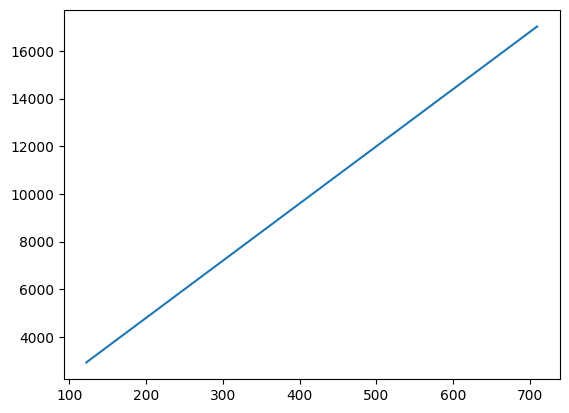

In [219]:
plt.plot(acq_dataset_active_sec, current_frame);

In [220]:
np.polyfit(
    np.array(acq_dataset_active_sec) - 0.016, 
    np.array(current_frame),
    deg=1,
    cov=True
)

(array([23.99981258, -0.04485999]),
 array([[ 3.69277130e-09, -1.52247775e-06],
        [-1.52247775e-06,  7.33564995e-04]]))

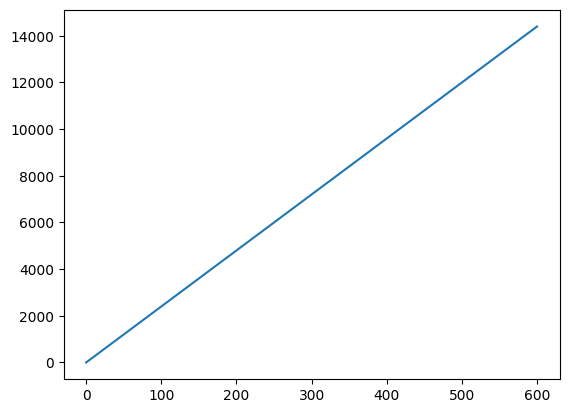

In [178]:
freq = 24.
period = 1 / freq
acq = 600 # s
frames = int(acq / period)

rng = np.random.default_rng(119009)
offsets = rng.uniform(high=period, size=frames)
f0 = np.arange(frames)

times = f0/24 + offsets
plt.plot(times, f0)
# plt.ylim(0, 40)
# plt.xlim(0, 1.75);

In [176]:
np.polyfit(times - period/2, f0, deg=1)

array([ 2.40000013e+01, -1.46609051e-03])